In [2]:
import pandas as pd
import numpy as np
import requests
import re
import json
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
###Bringing up all csvs from scraping
with open("../input/scrap/carso_casion.json", "r") as read_file:
    data = json.load(read_file)

FileNotFoundError: [Errno 2] No such file or directory: '../input/scrap/carso_casion.json'

In [67]:
###Concatenating dataframes
df1=pd.concat([df11,df12,df13,df14,df15,df16,df17,df18,df19],ignore_index=True)

In [68]:
dropcolumns=['Emisión CO2','Garantía','Color exterior','Autonomía','Peso Max.','Transmisión','Depósito','Vendedor','Altura','Anchura','Maletero']
df1.drop(dropcolumns, axis=1, inplace=True)
df1=pd.DataFrame(df1)
##df1.to_csv('./input/cars_all.csv', index=False)
##df1.to_json(r'./input/cars_all.json')

In [69]:
###df1=pd.read_csv("./output/cars.csv")
###df1=pd.DataFrame(df1)
###display(df1.head())

In [70]:
print(df1.shape)
print(df1.dtypes)

(59165, 23)
Precio          object
Año             object
Potencia        object
Kilómetros      object
Combustible     object
Puertas        float64
Cambio          object
Emisiones       object
Longitud        object
Plazas         float64
Peso            object
Carrocería      object
Vel. máxima     object
C. mixto        object
C. urbano       object
Extraurbano     object
0-100 km/h      object
Cilindrada      object
Cilindros       object
Par máximo      object
Marchas        float64
Tracción        object
model           object
dtype: object


In [71]:
df1=df1.dropna()
print(df1.shape)
##print(df1.isnull().sum())

(54183, 23)


In [72]:
print(df1['Carrocería'].value_counts())

Berlina                 25248
Todo Terreno            11801
Monovolumen              5686
Stationwagon             3624
Coupe                    2674
Furgon                   1531
Combi                    1483
Convertible              1172
Roadster                  595
Chasis                    162
Pick-Up Doble Cabina      116
Chasis Doble Cabina        39
Targa                      27
Pick-Up                    19
Bus                         6
Name: Carrocería, dtype: int64


In [73]:
def columnreplace(df,column,string):
    df[column]=df[column].str.replace(string,'')
    df[column]=df[column].str.replace(".",'')
    df[column]=df[column].astype('float')
    return df

In [74]:
def columnreplace2(df,column,string):
    df[column]=df[column].str.replace(string,'')
    df[column]=df[column].str.replace(",",'')
    df[column]=df[column].astype('float')/10
    return df

In [75]:
def columndigits(df,column):
    df[column]=[re.findall(r'\d+',i)[0] for i in df1[column]]
    return df

In [76]:
def columnlist(df,column):
    df[column]=df[column].str.replace("'",'')
    df[column]=df[column].str.replace("[",'')
    df[column]=df[column].str.replace("]",'')
    df[column]=[i.split(",") for i in df[column]]
    return df[column]

In [77]:
##Dropping rows in km
def removevalues(df1,column,value):
    indexNames = df1[ df1[column] == value].index
    df1.drop(indexNames , inplace=True)
    return df1

In [78]:
df1=removevalues(df1,"Kilómetros","NUEVO")
df1=removevalues(df1,"Combustible","Híbrido")
df1=removevalues(df1,"Combustible","Eléctrico")

In [63]:
##Dropping rows in Combustible (low freq of Hibrid and electric)
df1 = df1[df1["Combustible"] != "Híbrido"]
df1 = df1[df1["Combustible"] != "Eléctrico"]
print(df1["Combustible"].value_counts())

Diesel      35309
Gasolina    17433
Name: Combustible, dtype: int64


In [79]:
##Numerical columns (integers)
df1=columnreplace(df1,"Precio","€")
df1=columnreplace(df1,"Kilómetros"," km")
df1=columnreplace(df1,"Emisiones"," gr/mdiv3div")
df1=columnreplace(df1,"Cilindrada"," cmdiv3div")
df1=columnreplace(df1,"Par máximo"," Nm")
df1=columnreplace(df1,"Vel. máxima"," km/h")

##df1=columnreplace(df1,"Maletero"," l")
##df1=columnreplace(df1,"Depósito"," l")
df1=columnreplace(df1,"Longitud"," cm")
##df1=columnreplace(df1,"Anchura"," cm")
##df1=columnreplace(df1,"Altura"," cm")
df1=columnreplace(df1,"Peso"," kg")

##['Emisión CO2','Garantía','Color exterior','Autonomía','Peso Max.','Transmisión','Depósito',
##'Vendedor','Altura','Anchura','Maletero']

In [80]:
##Numerical columns (floats)
df1=columnreplace2(df1,"0-100 km/h"," s")
df1=columnreplace2(df1,"C. mixto"," l")
df1=columnreplace2(df1,"C. urbano"," l")
df1=columnreplace2(df1,"Extraurbano"," l")
##display(df1.head(5))

In [81]:
##Adjusting columns with numerical and non numerical
df1=columndigits(df1,'Potencia')
df1=columndigits(df1,'Cilindros')

##display(df1.head(5))

In [82]:
df1['model']=columnlist(df1,"model")
##display(df1.head(5))

In [83]:
df1['Provincia']=[i[1].strip() for i in df1['model']]
df1['Brand']=[i[2].strip() for i in df1['model']]
df1['Model']=[i[3].strip() for i in df1['model']]

In [84]:
##Dropping rows in km
##param
kmmax=300000
kmmin=2500

df1 = df1[df1["Kilómetros"] <=kmmax]
df1 = df1[df1["Kilómetros"] >=kmmin]

In [85]:
##candidate columns for get dummies
## Combustible
## Cambio
## Tracción
## Puertas

In [86]:
def cambio(cambio):
    if (cambio.lower()).find('secuencial')>-1:
        return 1
    if (cambio.lower()).find('automática')>-1:
        return 0.75
    else:
        return 0

In [87]:
def traccion(traccion):
    if (traccion.lower()).find('total')>-1:
        return 1
    if (traccion.lower()).find('trasera')>-1:
        return 0.5
    else:
        return 0

In [88]:
def puertas(puertas):
    if puertas>3:
        return 1
    else:
        return 0

In [89]:
def marchas(marchas):
    if marchas>=6:
        return 1
    else:
        return 0

In [90]:
df1['Cambio']=[cambio(i) for i in df1['Cambio']]
df1['Tracción']=[traccion(i) for i in df1['Tracción']]
df1['Puertas']=[puertas(i) for i in df1['Puertas']]
df1['Marchas']=[marchas(i) for i in df1['Marchas']]
##display(df1)

In [91]:
##Columna Año
##param
anmax=15
anmin=1

df1['Año'] = df1['Año'].str[-4:]
df1=df1.dropna()
df1['Año'] = df1['Año'].astype(int)
df1['Año']=2019-df1['Año']
df1 = df1[df1["Año"] <=anmax]
df1 = df1[df1["Año"] >=anmin]
print(df1['Año'].value_counts())

df1 = df1[df1["Precio"] <= 400000]

1     6710
4     5905
3     5523
2     5302
5     3106
6     2046
8     1923
7     1803
9     1504
12    1272
10    1181
11    1179
13    1007
14     777
15     625
Name: Año, dtype: int64


In [92]:
df1['Potencia']=df1['Potencia'].astype('float')
df1['Cilindros']=df1['Cilindros'].astype('float')

In [94]:
##Columns to drop
##dropcolumns2=['Vendedor','Altura','Anchura','Maletero','Provincia','model','Depósito']
##df1.drop(dropcolumns2, axis=1, inplace=True)
df1 = df1[df1["Longitud"] !=0]
df1 = df1[df1["Vel. máxima"] !=0]
df1 = df1[df1['C. mixto'] !=0]

In [95]:
print(df1.shape)

(37618, 26)


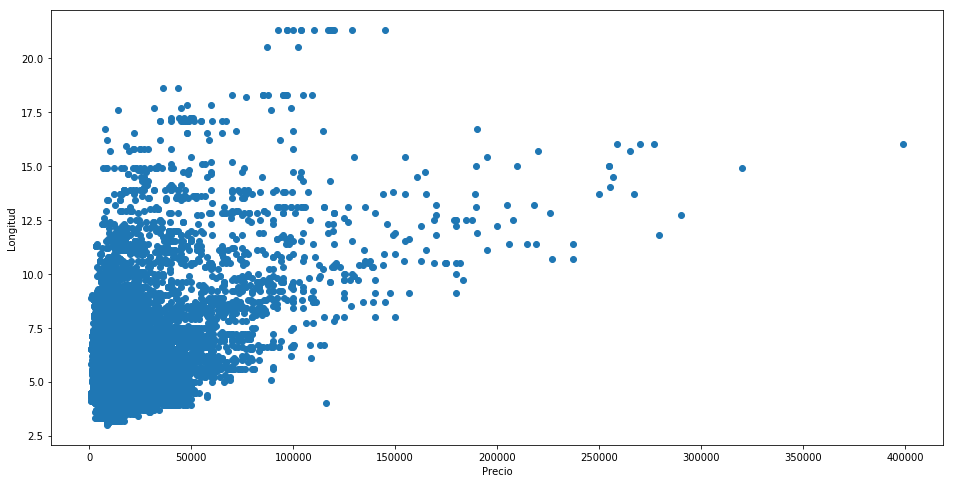

In [98]:
fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(df1['Precio'], df1['C. mixto'])
ax.set_xlabel('Precio')
ax.set_ylabel('Longitud')
plt.show()

In [99]:
##Removing low frequency columns
##Brand
##threshold = 100 # Anything that occurs less than this will be removed.
##value_counts = df1['Brand'].value_counts() # Specific column 
##to_remove = value_counts[value_counts <= threshold].index
##df1['Brand'].replace(to_remove, np.nan, inplace=True)
##df1=df1.dropna()

In [100]:
##Removing low frequency columns
def RemoveLowFreq(df,column,threshold):
    value_counts = df1[column].value_counts() # Specific column 
    to_remove = value_counts[value_counts <= threshold].index
    df[column].replace(to_remove, np.nan, inplace=True)
    df=df.dropna()
    return df

In [101]:
## Params low frequency
lf_model=100
lf_brand=200
lf_carro=1000

df1=RemoveLowFreq(df1,"Model",lf_model)
df1=RemoveLowFreq(df1,"Brand",lf_brand)
df1=RemoveLowFreq(df1,"Carrocería",lf_carro)

In [104]:
modelos=df1['Model'].value_counts()
display(modelos)

Volkswagen Golf       958
Seat León             862
Citroen C4            735
Audi A3               658
Nissan Qashqai        647
                     ... 
Hyundai Santa Fe      103
Peugeot 207            94
Mercedes Clase Cla     87
Mercedes Clase Glc     86
Citroen Berlingo        2
Name: Model, Length: 88, dtype: int64

In [105]:
for col in df1.columns: 
    print("'"+col+"'")

'Precio'
'Año'
'Potencia'
'Kilómetros'
'Combustible'
'Puertas'
'Cambio'
'Emisiones'
'Longitud'
'Plazas'
'Peso'
'Carrocería'
'Vel. máxima'
'C. mixto'
'C. urbano'
'Extraurbano'
'0-100 km/h'
'Cilindrada'
'Cilindros'
'Par máximo'
'Marchas'
'Tracción'
'model'
'Provincia'
'Brand'
'Model'


In [106]:
df1t = df1[['Precio','Año','Potencia','Kilómetros','Marchas','0-100 km/h','Cilindros','Tracción','Marchas']]
df1t.describe()

,Precio,Año,Potencia,Kilómetros,Marchas,0-100 km/h,Cilindros,Tracción,Marchas
count,24241.000000,24241.000000,24241.000000,24241.000000,24241.000000,24241.000000,24241.000000,24241.000000,24241.000000
mean,15309.982798,4.470278,134.202426,77856.187740,0.750258,10.408073,3.988449,0.150613,0.750258
std,9204.512529,3.337461,52.412662,55122.963272,0.432873,2.142736,0.618031,0.323617,0.432873
min,900.000000,1.000000,54.000000,2500.000000,0.000000,0.000000,2.000000,0.000000,0.000000
25%,9490.000000,2.000000,105.000000,30091.000000,1.000000,9.100000,4.000000,0.000000,1.000000
50%,13690.000000,4.000000,122.000000,70163.000000,1.000000,10.500000,4.000000,0.000000,1.000000
75%,18800.000000,6.000000,150.000000,110000.000000,1.000000,11.700000,4.000000,0.000000,1.000000
max,139999.000000,15.000000,612.000000,300000.000000,1.000000,18.200000,10.000000,1.000000,1.000000


AxesSubplot(0.125,0.125;0.62x0.755)


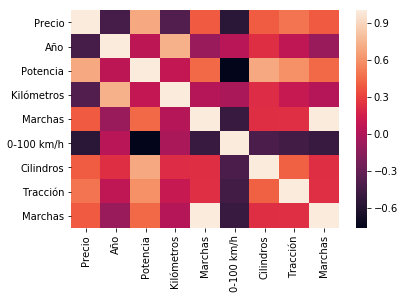

In [107]:
corrt = df1t.corr()
print(sns.heatmap(corrt))

In [108]:
print(df1.shape)

(24241, 26)


In [109]:
##dfbrands=df1['Brand'].value_counts()
##dfbrands.to_csv('./output/dfbrands.csv',index=True)

##dfmodels=df1['Model'].value_counts()
##dfmodels.to_csv('./output/dfmodels.csv',index=True)

In [116]:
##Reassiging Brands
Brand_dict={
'Porsche':1,
'Land Rover':1,
'Bmw':1,
'Audi':1,
'Mercedes':1,
'Mini':1,
'Lexus':1,
'Volvo':1,
'Volkswagen':0.7,
'Mazda':0.5,
'Honda':0.5,
'Nissan':0.5,
'Toyota':0.5,
'Ford':0.4,
'Opel':0.3,
'Peugeot':0.3,
'Renault':0.1,
'Seat':0.1,
'Citroen':0.1,
'Hyundai':0.1,
'Fiat':0.1,
'Kia':0.1,
'Skoda':0.1
}

In [117]:
df1['Brand_bin']=[Brand_dict[i] for i in df1['Brand']]
df1['Brand_bin']=df1['Brand_bin'].astype('float')

In [118]:
def columnBining(df,column,bins):
    newcolumn=column+"_bin"
    labels=[float((i+1)/bins)for i in range(bins)]
    df[newcolumn]=pd.qcut(df[column],bins,labels=labels)
    df[newcolumn]=df[newcolumn].astype('float')
    return df[newcolumn]

In [113]:
'''
##Bining of longitud/peso to try to adjust for brands distinct models
##param
ColumnsBin=['Longitud','Kilómetros','Peso','Potencia']
Bins={'Longitud':8,
      'Kilómetros':8,
      'Peso':8,
      'Potencia':8
     }

for i in ColumnsBin:
    columnBining(df1,i,Bins[i])
'''

SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-113-4d19bec500d6>, line 12)

In [120]:
print(df1.shape)

(24241, 29)


In [110]:
df1 = pd.get_dummies(df1, columns=['Combustible'])
df1 = pd.get_dummies(df1, columns=['Brand'])
df1 = pd.get_dummies(df1, columns=['Carrocería'])

In [111]:
def normalization(df,column):
    df[column]=(df[column]-np.mean(df[column]))/np.std(df[column])
    return df[column]

In [112]:
def normalizationmaxmin(df,column):
    df[column]=(df[column]-(df[column]).min())/((df[column]).max()-(df[column]).min())
    return df[column]

In [114]:
ColumnsNorm=['Emisiones','Longitud','Plazas','Peso','Cilindros','Vel. máxima','C. mixto','C. urbano','Extraurbano','0-100 km/h','Cilindrada','Cilindros','Par máximo',"Año",'Potencia','Kilómetros']
##ColumnsNormmaxmin=["Año",'Potencia','Kilómetros']

for col in ColumnsNorm:
    normalization(df1,col)

##for col in ColumnsNormmaxmin:
##    normalizationmaxmin(df1,col)

AxesSubplot(0.125,0.125;0.62x0.755)


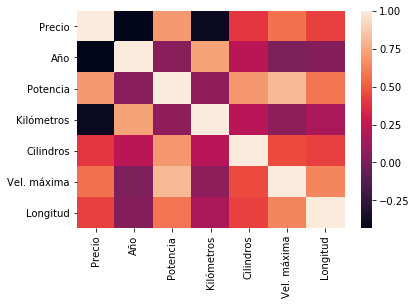

In [116]:
##Checking correlation
df2 = df1[['Precio','Año','Potencia','Kilómetros','Cilindros','Vel. máxima','Longitud']]
corr2 = df2.corr()
print(sns.heatmap(corr2))

In [117]:
df2.describe()

,Precio,Año,Potencia,Kilómetros,Cilindros,Vel. máxima,Longitud
count,24241.000000,2.424100e+04,2.424100e+04,2.424100e+04,2.424100e+04,2.424100e+04,2.424100e+04
mean,15309.982798,-2.344929e-17,2.767016e-16,8.910729e-17,2.227682e-17,-3.071857e-16,-1.758697e-16
std,9204.512529,1.000021e+00,1.000021e+00,1.000021e+00,1.000021e+00,1.000021e+00,1.000021e+00
min,900.000000,-1.039817e+00,-1.530242e+00,-1.367084e+00,-3.217461e+00,-2.739848e+00,-3.226294e+00
25%,9490.000000,-7.401819e-01,-5.571751e-01,-8.665386e-01,1.868987e-02,-7.304864e-01,-5.462824e-01
50%,13690.000000,-1.409117e-01,-2.328193e-01,-1.395670e-01,1.868987e-02,-9.337171e-02,-1.689747e-02
75%,18800.000000,4.583585e-01,3.014138e-01,5.831413e-01,1.868987e-02,6.417607e-01,7.771800e-01
max,139999.000000,3.155075e+00,9.116260e+00,4.030052e+00,9.727141e+00,5.052555e+00,2.034469e+00


In [118]:
##weighted params
n_km=1
n_ano=1.1
n_pot=1.1

###df1.dtypes
df1["Kilómetros"]=df1["Kilómetros"]*n_km
df1["Año"]=df1["Año"]*n_ano
df1["Potencia"]=df1["Potencia"]*n_pot

In [119]:
for col in df1.columns: 
    print("'"+col+"'") 

'Precio'
'Año'
'Potencia'
'Kilómetros'
'Puertas'
'Cambio'
'Emisiones'
'Longitud'
'Plazas'
'Peso'
'Vel. máxima'
'C. mixto'
'C. urbano'
'Extraurbano'
'0-100 km/h'
'Cilindrada'
'Cilindros'
'Par máximo'
'Marchas'
'Tracción'
'model'
'Provincia'
'Model'
'Combustible_Diesel'
'Combustible_Gasolina'
'Brand_Audi'
'Brand_Bmw'
'Brand_Citroen'
'Brand_Fiat'
'Brand_Ford'
'Brand_Hyundai'
'Brand_Kia'
'Brand_Land Rover'
'Brand_Mazda'
'Brand_Mercedes'
'Brand_Mini'
'Brand_Nissan'
'Brand_Opel'
'Brand_Peugeot'
'Brand_Porsche'
'Brand_Renault'
'Brand_Seat'
'Brand_Skoda'
'Brand_Toyota'
'Brand_Volkswagen'
'Brand_Volvo'
'Carrocería_Berlina'
'Carrocería_Monovolumen'
'Carrocería_Stationwagon'
'Carrocería_Todo Terreno'


In [120]:
df1.to_csv('./output/cars_clean.csv', index=False)

In [121]:
# Importing libraries:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix, accuracy_score

from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_classification
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression

from math import sqrt

In [123]:
##columns = ['Año','Potencia','Kilómetros','Puertas','Emisiones','Longitud','Par máximo','Peso','Cilindros',
##           'Marchas','Tracción','Combustible_Diesel','Combustible_Eléctrico','Vel. máxima','C. mixto','0-100 km/h','Extraurbano']

columns = [
'Año',
'Potencia',
'Kilómetros',
'Puertas',
'Cambio',
'Cilindros',
'Marchas',
'Tracción',
'Longitud',
'Plazas',
'Combustible_Diesel',
'Combustible_Gasolina',
'Brand_Audi',
'Brand_Bmw',
'Brand_Citroen',
'Brand_Fiat',
'Brand_Ford',
'Brand_Hyundai',
'Brand_Kia',
'Brand_Land Rover',
'Brand_Mazda',
'Brand_Mercedes',
'Brand_Mini',
'Brand_Nissan',
'Brand_Opel',
'Brand_Peugeot',
'Brand_Porsche',
'Brand_Renault',
'Brand_Seat',
'Brand_Skoda',
'Brand_Toyota',
'Brand_Volkswagen',
'Brand_Volvo',
'Carrocería_Berlina',
'Carrocería_Monovolumen',
'Carrocería_Stationwagon',
'Carrocería_Todo Terreno'
]

X = df1[columns]
y = df1['Precio']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
print(X.shape,y.shape)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
##display(X.head())
##display(y.head())

(24241, 37) (24241,)
(19392, 37) (4849, 37) (19392,) (4849,)


In [124]:
#clf = reg = LinearRegression()
clf = RandomForestRegressor(n_estimators=300)
#clf = reg = GradientBoostingRegressor()

In [125]:
clf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=300, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [126]:
y_predr = clf.predict(X_test)

In [127]:
r2_score=r2_score(y_test, y_predr)
print("r2_score is: {}".format(r2_score))
rmse = sqrt(mean_squared_error(y_test, y_predr))
print("rmse is: {}".format(rmse))

r2_score is: 0.9410519517583741
rmse is: 2235.9810912576945


In [268]:
## RandomForestRegressor(n_estimators=250)
##r2_score is: 0.955718173117974
##rmse is: 1867.7555784521455

In [269]:
## GradientBoostingRegressor()
##r2_score is: 0.9270101386305405
##rmse is: 3195.9955213308585